In [1]:
%env DB_HOST=mongodb://localhost/openpath_prod_ca_ebike
import emission.core.get_database as edb
import emission.storage.timeseries.aggregate_timeseries as esta
import emission.storage.timeseries.builtin_timeseries as estb
import emission.core.get_database as gdb

env: DB_HOST=mongodb://localhost/openpath_prod_ca_ebike
Config file not found, returning a copy of the environment variables instead...
Retrieved config: {'DB_HOST': 'mongodb://localhost/openpath_prod_ca_ebike', 'DB_RESULT_LIMIT': None}
Connecting to database URL mongodb://localhost/openpath_prod_ca_ebike


In [2]:
# Count the total number of documents with metadata.key = "stats/pipeline_time" in Stage_timeseries
pipeline_time_count = gdb.get_timeseries_db().count_documents({
    "metadata.key": "stats/pipeline_time"
})
print(f"Total documents in Stage_timeseries with metadata.key 'stats/pipeline_time': {pipeline_time_count}")


Total documents in Stage_timeseries with metadata.key 'stats/pipeline_time': 215954


In [3]:
# Count the total number of documents with metadata.key = "stats/dashboard_time" in Stage_timeseries
dashboard_time_count = gdb.get_timeseries_db().count_documents({
    "metadata.key": "stats/dashboard_time"
})
print(f"Total documents in Stage_timeseries with metadata.key 'stats/dashboard_time': {dashboard_time_count}")


Total documents in Stage_timeseries with metadata.key 'stats/dashboard_time': 5960


In [25]:
# # Fetch documents with metadata.key = "stats/pipeline_time"
# pipeline_docs_cursor = gdb.get_timeseries_db().find({
#     "metadata.key": "stats/pipeline_time"
# })

# # Display a sample of the documents
# import pprint
# pipeline_docs = list(pipeline_docs_cursor)
# if pipeline_docs:
#     single_doc = pipeline_docs[0]
#     print("Single Document:")
#     pprint.pprint(single_doc)
# else:
#     print("No documents found for 'stats/pipeline_time'.")

# # Fetch multiple documents
# pipeline_docs_sample = pipeline_docs[:5]  # Get first 5 documents
# print("\nMultiple Documents:")
# for doc in pipeline_docs_sample:
#     pprint.pprint(doc)


In [1]:
# import pandas as pd

# # Fetch up to 100 documents for analysis
# documents_cursor = gdb.get_timeseries_db().find({"metadata.key": "stats/pipeline_time"}).limit(100)
# documents = list(documents_cursor)
# df = pd.json_normalize(documents)

# # Display DataFrame columns and data types
# print("\nDataFrame Columns and Data Types:")
# print(df.dtypes)

# # Display summary statistics
# print("\nDataFrame Description:")
# print(df.describe(include='all'))

# # Display the first few rows
# print("\nFirst Five Rows of DataFrame:")
# print(df.head())


In [6]:
# Define the aggregation pipeline as a function
def process_pipeline_data(data_df):
    # Filter documents where metadata.key is 'stats/pipeline_time'
    filtered_df = data_df[data_df['metadata.key'] == 'stats/pipeline_time']
    
    # Group by year, month, and day to calculate statistics on `data.reading`
    grouped_df = filtered_df.groupby(
        ['metadata.write_local_dt.year', 'metadata.write_local_dt.month', 'metadata.write_local_dt.day']
    ).agg(
        avgPipelineTime=('data.reading', 'mean'),
        minPipelineTime=('data.reading', 'min'),
        maxPipelineTime=('data.reading', 'max'),
        count=('data.reading', 'size'),
        medianPipelineTime=('data.reading', 'median'),
        stdPipelineTime=('data.reading', 'std')
    ).reset_index()

    return grouped_df

# Convert the aggregation results into a Pandas DataFrame for easier data manipulation
agg_df = process_pipeline_data(df)

# Display the first few rows of the aggregated DataFrame
print("\nAggregation Results:")
print(agg_df.head())



Aggregation Results:
   metadata.write_local_dt.year  metadata.write_local_dt.month  \
0                          2023                              6   
1                          2023                              8   

   metadata.write_local_dt.day  avgPipelineTime  minPipelineTime  \
0                           27         0.045514         0.008508   
1                           20         0.429376         0.024695   

   maxPipelineTime  count  medianPipelineTime  stdPipelineTime  
0         0.363280     92            0.022880         0.071765  
1         1.372567      8            0.262803         0.480504  


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# Set the visual style
sns.set(style="whitegrid")


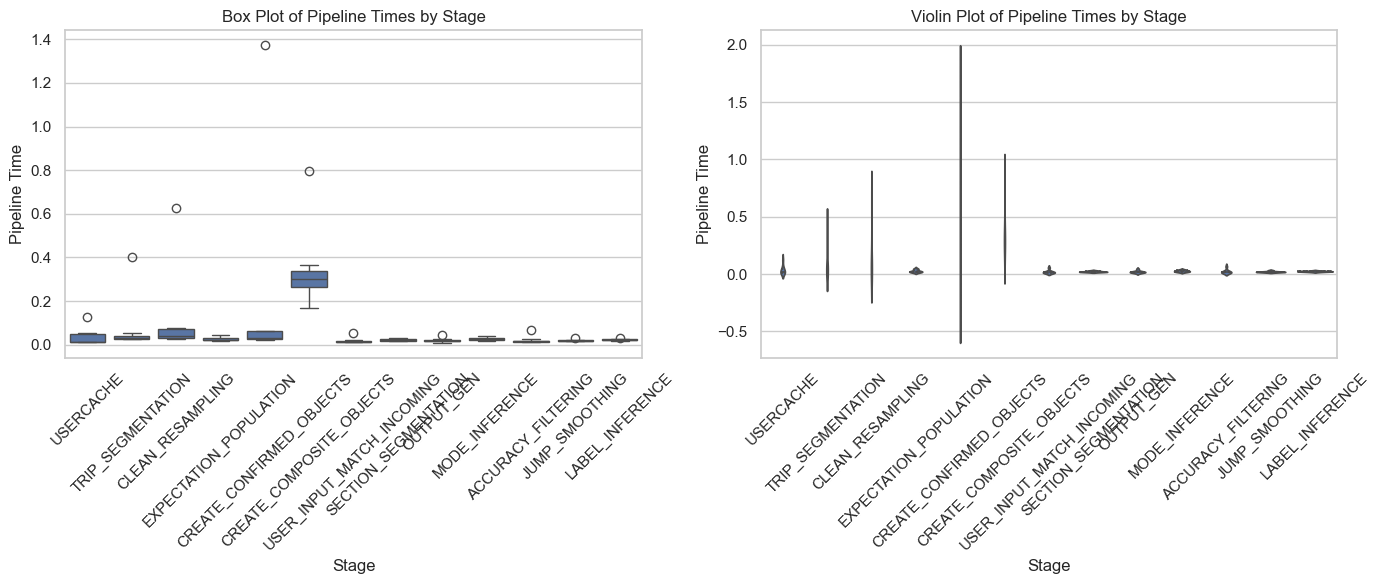

In [9]:
# Function to visualize the distribution of pipeline times
def visualize_pipeline_time_distribution(data_df):
    plt.figure(figsize=(14, 6))
    
    # Box Plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='data.name', y='data.reading', data=data_df)
    plt.title('Box Plot of Pipeline Times by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time')
    plt.xticks(rotation=45)
    
    # Violin Plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x='data.name', y='data.reading', data=data_df, inner='quartile')
    plt.title('Violin Plot of Pipeline Times by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualize the distribution of pipeline times
visualize_pipeline_time_distribution(df)


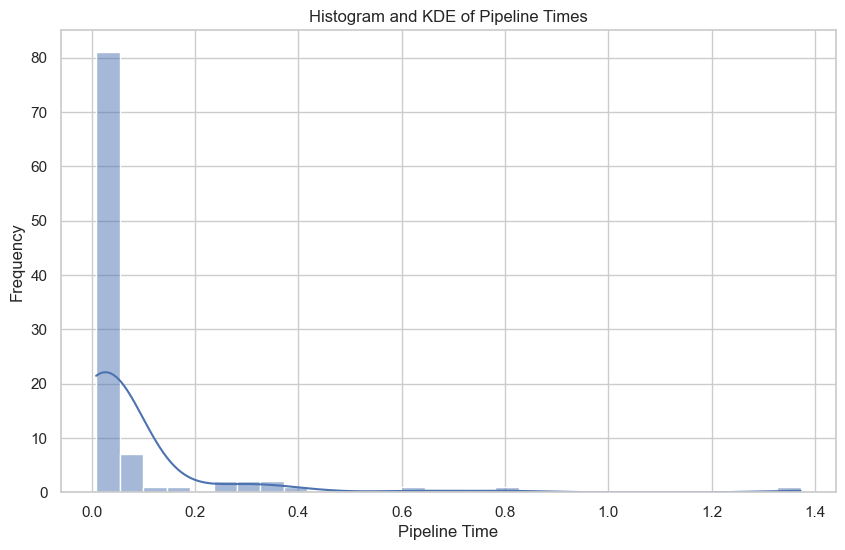

In [10]:
# Additional Analysis: Histogram and KDE
def plot_histogram_kde(data_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(data_df['data.reading'], bins=30, kde=True)
    plt.title('Histogram and KDE of Pipeline Times')
    plt.xlabel('Pipeline Time')
    plt.ylabel('Frequency')
    plt.show()

plot_histogram_kde(df)


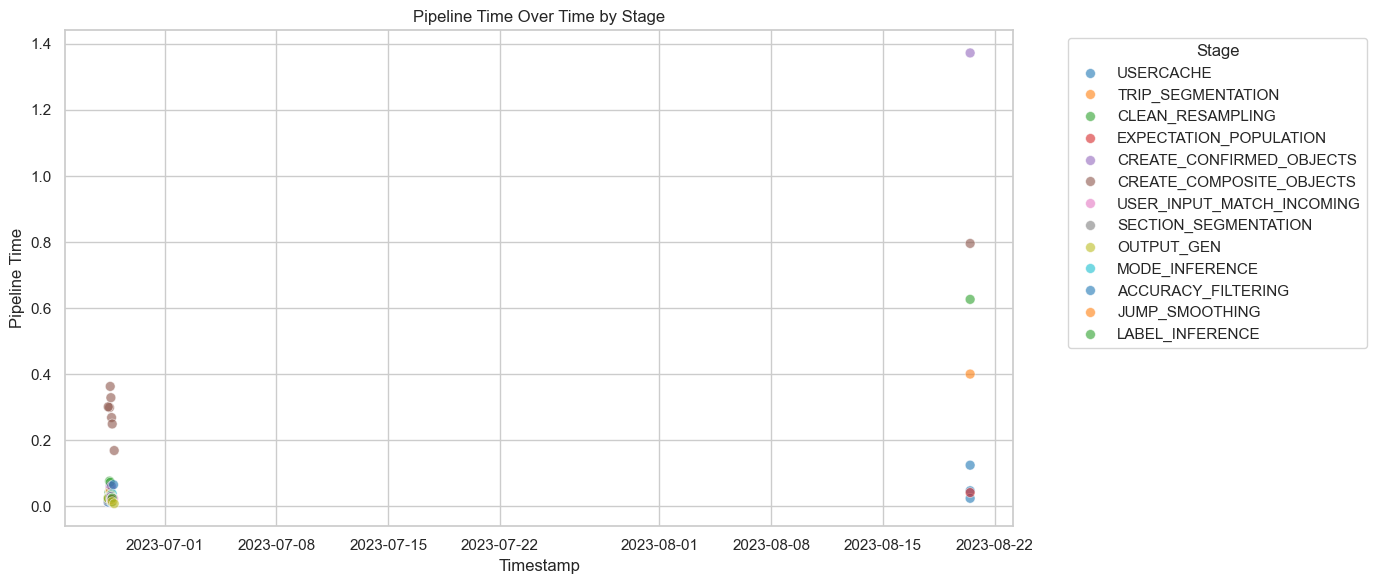

In [22]:
# Scatter Plot: Pipeline Time vs. Timestamp
def plot_scatter_time(data_df):
    plt.figure(figsize=(14, 6))
    
    # Convert write_fmt_time to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(data_df['metadata.write_fmt_time']):
        data_df['metadata.write_fmt_time'] = pd.to_datetime(data_df['metadata.write_fmt_time'], errors='coerce')
    
    # Ensure there are no missing values in 'metadata.write_fmt_time' and 'data.reading'
    data_df = data_df.dropna(subset=['metadata.write_fmt_time', 'data.reading', 'data.name'])
    
    # Create the scatter plot with the data parameter
    sns.scatterplot(
        x='metadata.write_fmt_time',
        y='data.reading',
        hue='data.name',
        data=data_df,           # Pass the DataFrame here
        alpha=0.6,
        palette='tab10',
        s=50
    )
    
    plt.title('Pipeline Time Over Time by Stage')
    plt.xlabel('Timestamp')
    plt.ylabel('Pipeline Time')
    plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Execute the corrected function
plot_scatter_time(df)



Correlation Matrix:
                               data.reading  metadata.write_local_dt.year  \
data.reading                       1.000000                           NaN   
metadata.write_local_dt.year            NaN                           NaN   
metadata.write_local_dt.month      0.584963                           NaN   
metadata.write_local_dt.day       -0.584963                           NaN   

                               metadata.write_local_dt.month  \
data.reading                                        0.584963   
metadata.write_local_dt.year                             NaN   
metadata.write_local_dt.month                       1.000000   
metadata.write_local_dt.day                        -1.000000   

                               metadata.write_local_dt.day  
data.reading                                     -0.584963  
metadata.write_local_dt.year                           NaN  
metadata.write_local_dt.month                    -1.000000  
metadata.write_local_dt.day 

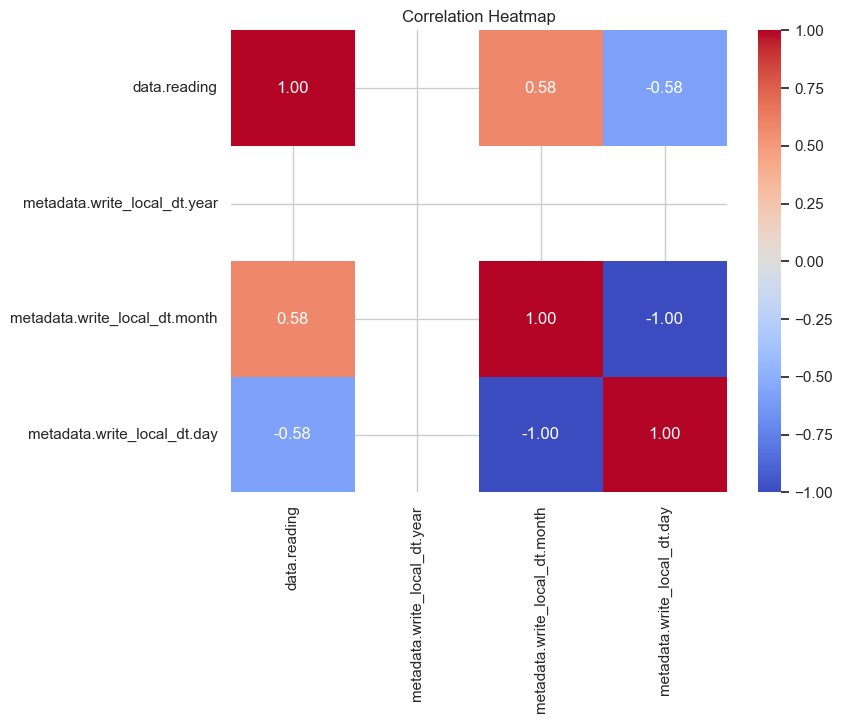

Correlation Heatmap displayed.


In [12]:
# Correlation Analysis
def correlation_analysis(data_df):
    numeric_cols = ['data.reading', 'metadata.write_local_dt.year', 'metadata.write_local_dt.month', 'metadata.write_local_dt.day']
    corr = data_df[numeric_cols].corr()
    print("\nCorrelation Matrix:")
    print(corr)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
    print("Correlation Heatmap displayed.")

correlation_analysis(df)



Summary Statistics by Stage:
                    data.name      mean    median       min       max  \
0          ACCURACY_FILTERING  0.022217  0.014708  0.012863  0.065780   
1            CLEAN_RESAMPLING  0.117107  0.037818  0.025608  0.626720   
2    CREATE_COMPOSITE_OBJECTS  0.347181  0.300491  0.169232  0.795990   
3    CREATE_CONFIRMED_OBJECTS  0.203901  0.029135  0.022666  1.372567   
4      EXPECTATION_POPULATION  0.026884  0.021575  0.017100  0.045405   
5              JUMP_SMOOTHING  0.020418  0.018696  0.016011  0.031645   
6             LABEL_INFERENCE  0.023303  0.023092  0.017572  0.030340   
7              MODE_INFERENCE  0.026617  0.025605  0.016819  0.038714   
8                  OUTPUT_GEN  0.020048  0.017592  0.008508  0.043452   
9        SECTION_SEGMENTATION  0.021949  0.019715  0.017593  0.030204   
10          TRIP_SEGMENTATION  0.079132  0.032304  0.024396  0.400698   
11                  USERCACHE  0.034969  0.013548  0.011695  0.124908   
12  USER_INPUT_MATCH_

/var/folders/8j/284cnbzn2tzbfljhtsr17gsx2490jk/T/ipykernel_26983/1996108215.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='data.name', y='mean', data=summary, palette='viridis')


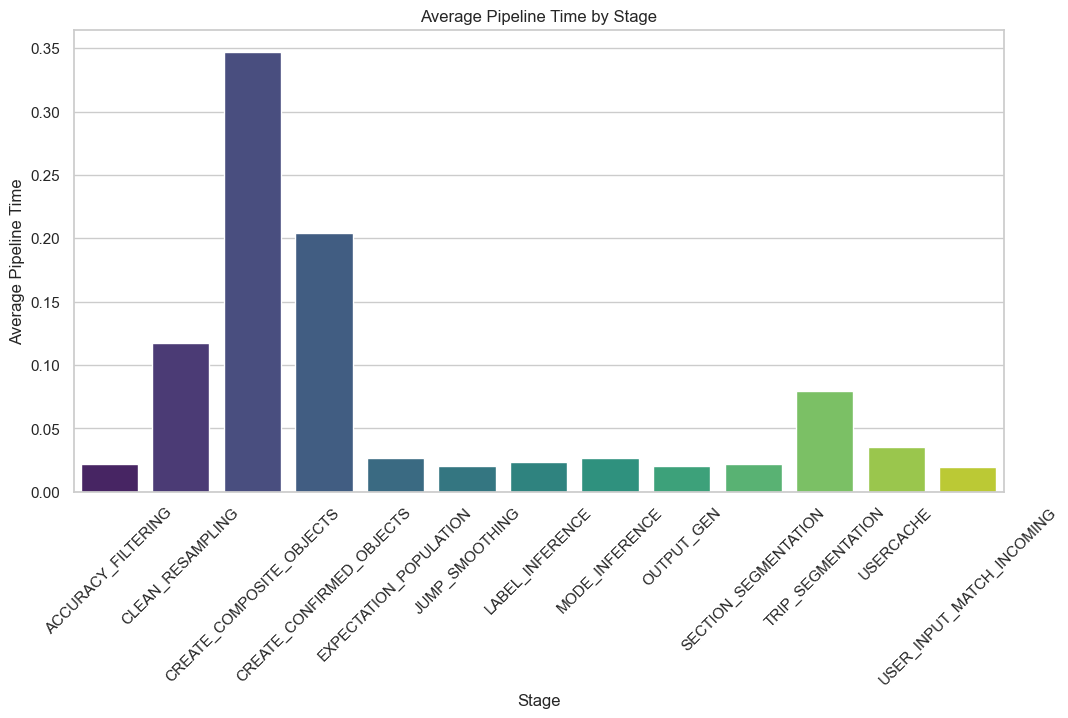

In [13]:
# Summary Statistics by Stage
def summary_stats_by_stage(data_df):
    summary = data_df.groupby('data.name')['data.reading'].agg(['mean', 'median', 'min', 'max', 'std', 'count']).reset_index()
    print("\nSummary Statistics by Stage:")
    print(summary)
    
    # Plotting the summary statistics
    plt.figure(figsize=(12, 6))
    sns.barplot(x='data.name', y='mean', data=summary, palette='viridis')
    plt.title('Average Pipeline Time by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Average Pipeline Time')
    plt.xticks(rotation=45)
    plt.show()

summary_stats_by_stage(df)


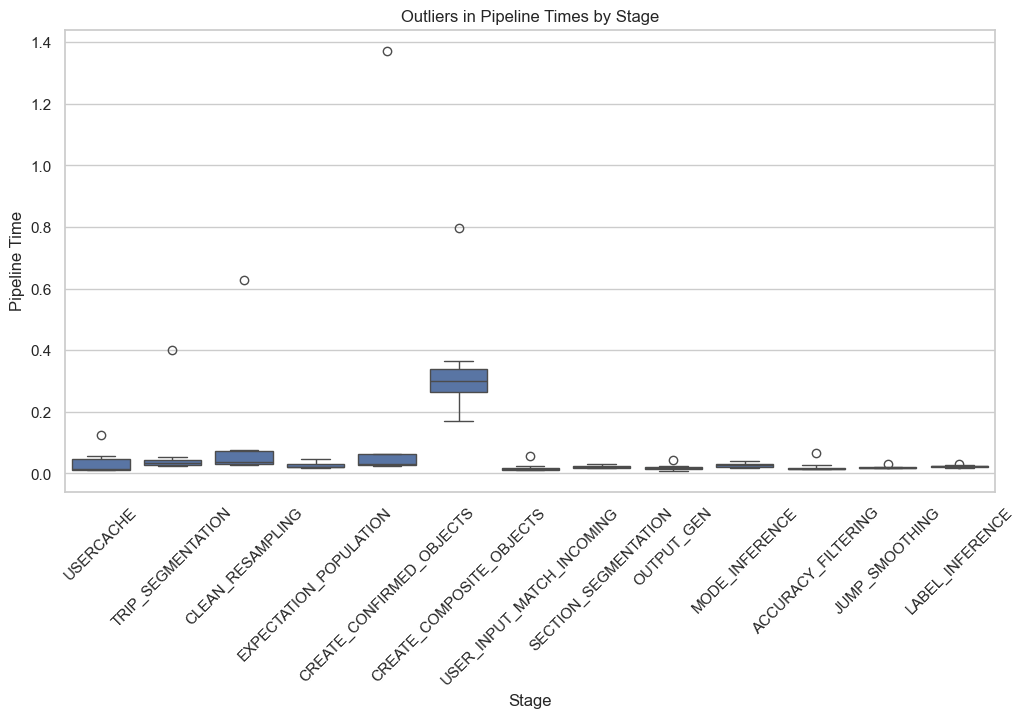

In [14]:
# Identifying Outliers
def identify_outliers(data_df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='data.name', y='data.reading', data=data_df)
    plt.title('Outliers in Pipeline Times by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time')
    plt.xticks(rotation=45)
    plt.show()

identify_outliers(df)


In [16]:
# Function to get pipeline time by stage for each user and across all users
def get_pipeline_time_by_stage(data_df):
    # Calculate the average time for each stage (data.name) for each user
    user_stage_avg = data_df.groupby(['user_id', 'data.name'])['data.reading'].mean().reset_index()
    
    # Calculate the average time for each stage across all users
    all_users_stage_avg = data_df.groupby('data.name')['data.reading'].mean().reset_index()
    
    return user_stage_avg, all_users_stage_avg


In [23]:
# Get the pipeline time by stage
user_stage_avg_df, all_users_stage_avg_df = get_pipeline_time_by_stage(df)

# Display the results
# print("Average Stage Times for Each User (First 5 Rows):")
# print(user_stage_avg_df.head())

print("\nAverage Stage Times Across All Users:")
print(all_users_stage_avg_df)



Average Stage Times Across All Users:
                    data.name  data.reading
0          ACCURACY_FILTERING      0.022217
1            CLEAN_RESAMPLING      0.117107
2    CREATE_COMPOSITE_OBJECTS      0.347181
3    CREATE_CONFIRMED_OBJECTS      0.203901
4      EXPECTATION_POPULATION      0.026884
5              JUMP_SMOOTHING      0.020418
6             LABEL_INFERENCE      0.023303
7              MODE_INFERENCE      0.026617
8                  OUTPUT_GEN      0.020048
9        SECTION_SEGMENTATION      0.021949
10          TRIP_SEGMENTATION      0.079132
11                  USERCACHE      0.034969
12  USER_INPUT_MATCH_INCOMING      0.019591


/var/folders/8j/284cnbzn2tzbfljhtsr17gsx2490jk/T/ipykernel_26983/357958289.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='data.name', y='data.reading', data=all_users_stage_avg_df, palette='magma')


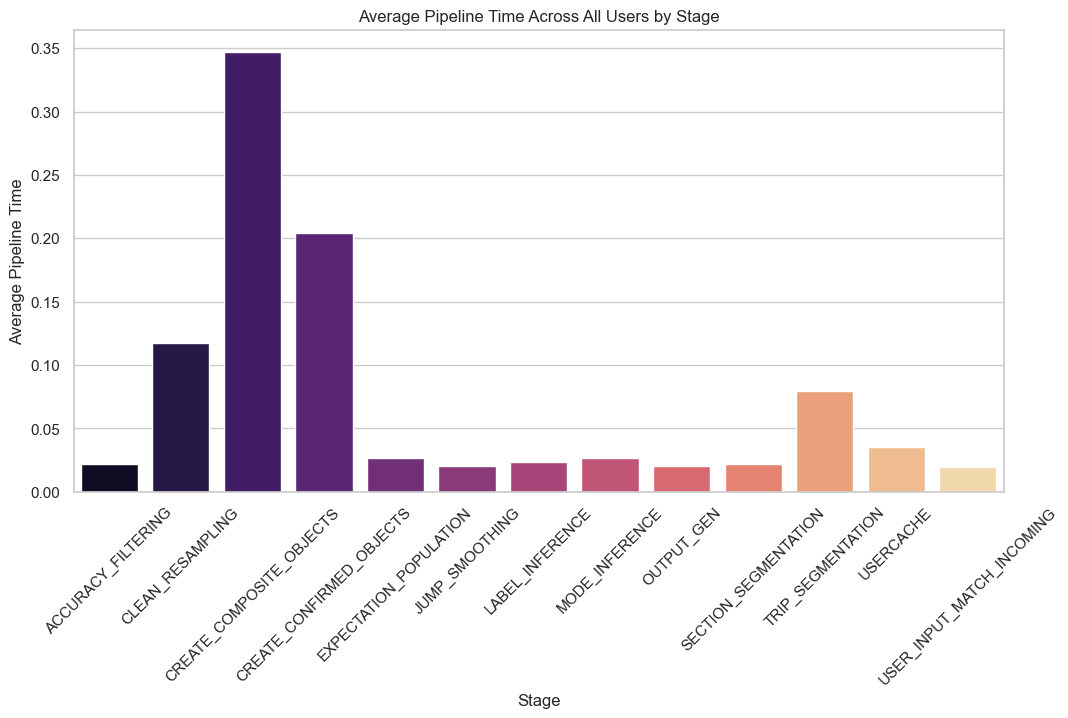

In [18]:
# Visualize Average Pipeline Time Across All Users by Stage
def plot_average_pipeline_time(all_users_stage_avg_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='data.name', y='data.reading', data=all_users_stage_avg_df, palette='magma')
    plt.title('Average Pipeline Time Across All Users by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Average Pipeline Time')
    plt.xticks(rotation=45)
    plt.show()

plot_average_pipeline_time(all_users_stage_avg_df)


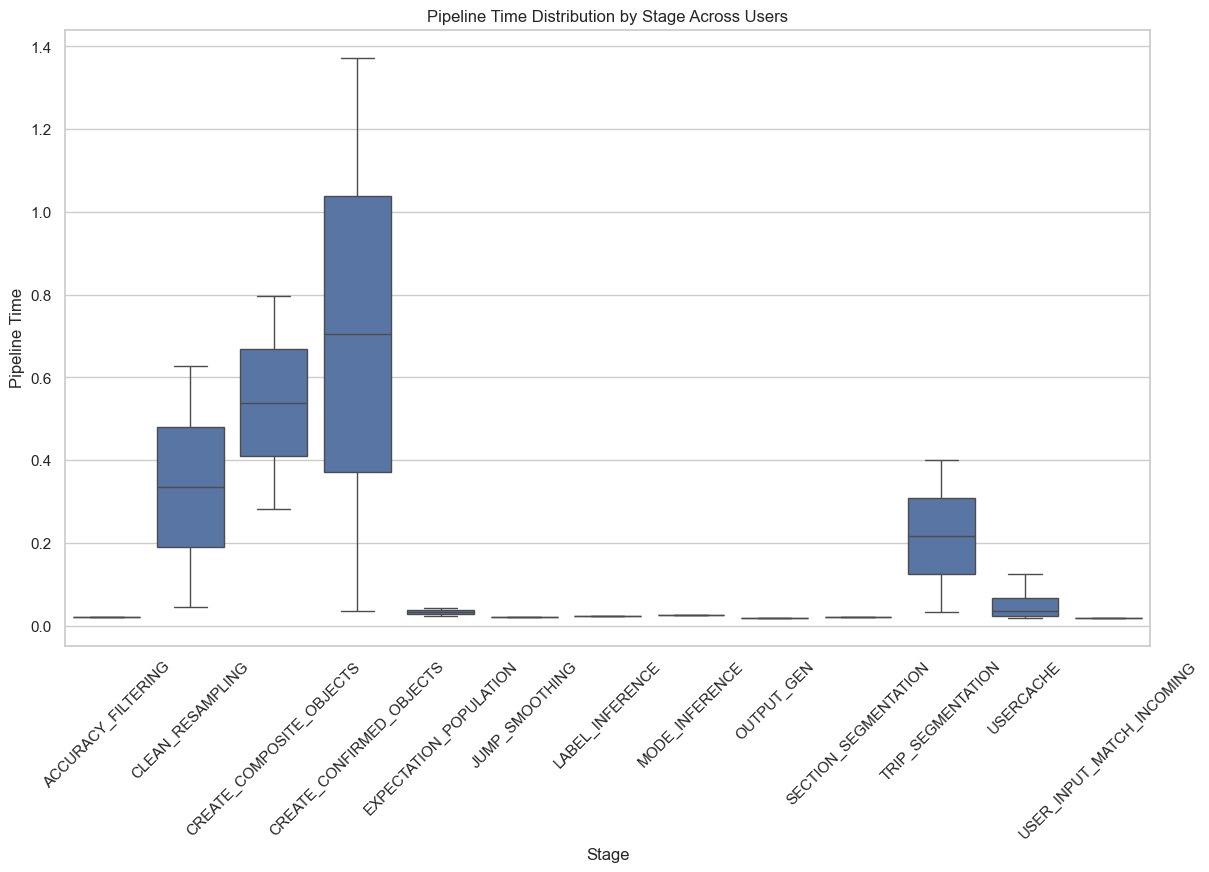

In [19]:
# Visualize User-Specific Pipeline Times
def plot_user_pipeline_times(user_stage_avg_df):
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='data.name', y='data.reading', data=user_stage_avg_df)
    plt.title('Pipeline Time Distribution by Stage Across Users')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time')
    plt.xticks(rotation=45)
    plt.show()

plot_user_pipeline_times(user_stage_avg_df)


In [24]:
# Investigate Low Average Pipeline Time
def investigate_low_avg(data_df):
    # Check for zeros or extremely low values
    low_threshold = data_df['data.reading'].quantile(0.05)
    low_values = data_df[data_df['data.reading'] < low_threshold]
    print(f"\nNumber of records with pipeline time below the 5th percentile ({low_threshold}): {low_values.shape[0]}")
    
    if not low_values.empty:
        print("\nSample of Low Pipeline Time Records:")
        #print(low_values.head())

investigate_low_avg(df)



Number of records with pipeline time below the 5th percentile (0.011759858101140708): 5

Sample of Low Pipeline Time Records:
